<a href="https://colab.research.google.com/github/anastaszi/255-DM-TeamProject/blob/shreyaghotankar%2Fcode/CMPE255_Project_MAPS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CMPE 255 - Project
**California House Price Prediction**

**Team Members**
* Manjiri Kadam
* Anastasia Zimina
* Parvathi Pai
* Shreya Ghotankar



---



---


**CRISP-DM**


* Business Understanding
* Data Understanding
* Data Preparation 
* Modeling 
* Evaluation 
* Deployment



---



---



Business Understanding - House prices are always changing and it is humanly impossible to determine what the price might be tomorrow. So with help of historical data and using machine learning algorithms help people to make offers based on the predicted prices that will increase the probability of buying.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing Library

In [ ]:
!pip install plotly
!pip install uszipcode
!pip install shap
!pip install catboost

     |████████████████████████████████| 454 kB 10.2 MB/s 
     |████████████████████████████████| 78 kB 6.6 MB/s 
     |████████████████████████████████| 45 kB 2.8 MB/s 
     |████████████████████████████████| 42 kB 714 kB/s 
     |████████████████████████████████| 564 kB 8.3 MB/s 
     |████████████████████████████████| 76.3 MB 1.2 MB/s 


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np

import pandas as pd
import seaborn as sns; sns.set()

import sklearn
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, LabelEncoder
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold
from yellowbrick.features.pca import (PCADecomposition)

from sklearn.cluster import KMeans

# metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, f1_score, confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score, classification_report

# Regression
import time
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold, cross_val_score
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

# for web scraping weather information
import requests
from bs4 import BeautifulSoup

import csv

try:
  from urllib.request import urlopen
except ImportError:
  from urllib2 import urlopen

# for web scraping zip codes

from uszipcode import SearchEngine

# for webscraping altitudes
import json
import urllib
import urllib3

# Density plot
from scipy.stats import gaussian_kde

# for SHAP values

import shap

# warnings
import warnings
warnings.filterwarnings('ignore')

#visuallizer
from yellowbrick.cluster.silhouette import SilhouetteVisualizer

import matplotlib.image as mpimg
import math

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from pandas.plotting import scatter_matrix
from scipy.special import boxcox, inv_boxcox

from scipy.stats import linregress

import pickle

from sklearn.metrics import silhouette_score
import re

from yellowbrick.features import FeatureImportances


import plotly.express as px

from time import time


In [ ]:
req_headers = {
    'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8',
    'accept-encoding': 'gzip, deflate, br',
    'accept-language': 'en-US,en;q=0.8',
    'upgrade-insecure-requests': '1',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36'
}

In [ ]:
# setting maximum column width and display max columns
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

## Data Collection and Understanding 

[Dataset](https://drive.google.com/file/d/1C4jKOf9MSb51I8uozUwGKs6bk-LUXKhB/view?usp=sharing): Zillow listing of houses, condos, townhomes

The dataset has listing from Zillow real estate website where different types of houses like single family homes, townhomes and condos are listed by buyers and real estate agents. This dataset has listing from different cities. As our goal is to predict house price in California we have started by filtering the dataset on 'CA' region.

In [ ]:
## parvathi path
df=pd.read_csv('/content/drive/MyDrive/CMPE255-DM-Project/Dataset/Dataset_Realestate.csv')
# df = pd.read_csv('/content/drive/MyDrive/CMPE255 - Data Mining/CMPE255-DM-Project/Dataset/Dataset_Realestate.csv')

In [ ]:
df.head()

,rank,property_id,address,latitude,longitude,price,currency,bathrooms,bedrooms,area,land_area,zestimate,rent_zestimate,days_on_zillow,sold_date,is_zillow_owned,image,listing_type,broker_name,input,property_url,listing_url
0,205,70983496,"109 Sunrise Fls, Cibolo, TX 78108",29.599431,-98.254866,296000.0,USD,3.0,3.0,2294.0 sqft,NaN,270100.0,2024.0,0.0,NaN,False,https://photos.zillowstatic.com/fp/41ca49058594aa920764c275348a1a5b-p_e.jpg,House for sale,Opendoor Brokerage LLC,https://www.zillow.com/homes/TX_rb/,https://www.zillow.com/homedetails/109-Sunrise-Fls-Cibolo-TX-78108/70983496_zpid/,https://www.zillow.com/homes/TX_rb/6_p/
1,711,30429260,"299 Mount Whitney Way, Lake Placid, NY 12946",44.306944,-73.950285,1995000.0,USD,5.0,4.0,3000.0 sqft,NaN,NaN,NaN,0.0,NaN,False,https://photos.zillowstatic.com/fp/3071787e4e53ff37262f4f8a7e28b740-p_e.jpg,House for sale,"Listing by: Merrill L. Thomas, Inc.",https://www.zillow.com/homes/NY_rb/,https://www.zillow.com/homedetails/299-Mount-Whitney-Way-Lake-Placid-NY-12946/30429260_zpid/,https://www.zillow.com/homes/NY_rb/18_p/
2,66,97629907,"2910 Persimmon Grv, Richmond, TX 77469",29.557442,-95.751786,425000.0,USD,3.0,2.0,2575.0 sqft,NaN,436000.0,2967.0,0.0,NaN,False,https://photos.zillowstatic.com/fp/f4716b346d1f1ed2de4aa9feffaca33a-p_e.jpg,House for sale,CENTURY 21 Western Realty,https://www.zillow.com/homes/TX_rb/,https://www.zillow.com/homedetails/2910-Persimmon-Grv-Richmond-TX-77469/97629907_zpid/,https://www.zillow.com/homes/TX_rb/2_p/
3,222,240296342,"19251 E State Route 106, Belfair, WA 98528",47.427678,-122.855113,895000.0,USD,2.0,2.0,1248.0 sqft,NaN,NaN,1969.0,0.0,NaN,False,https://photos.zillowstatic.com/fp/690e2ee9c080ca2569a879c42777d3ee-p_e.jpg,Active,NaN,https://www.zillow.com/homes/WA_rb/,https://www.zillow.com/homedetails/19251-E-State-Route-106-Belfair-WA-98528/240296342_zpid/,https://www.zillow.com/homes/WA_rb/6_p/
4,444,2076995275,"Clover Plan, The Alpine Collection at Altaira at High Point",39.813670,-104.765885,391500.0,USD,3.0,4.0,1752.0 sqft,NaN,NaN,1756.0,9.0,NaN,False,https://photos.zillowstatic.com/fp/9b2ae0d3768684967fdcd6cfd81b1039-p_e.jpg,New construction,NaN,"https://www.zillow.com/homes/denver,-co_rb/",https://www.zillow.com/community/alpine-collection-at-altaira-at-high-point/2076995275_zpid/,"https://www.zillow.com/homes/denver,-co_rb/12_p/"


Extracting data only for California

In [ ]:
df_cali=df[(df.address.str.contains('[.\s]*ca\s\d{5}$', flags=re.IGNORECASE|re.DOTALL)==True)]
df_cali

,rank,property_id,address,latitude,longitude,price,currency,bathrooms,bedrooms,area,land_area,zestimate,rent_zestimate,days_on_zillow,sold_date,is_zillow_owned,image,listing_type,broker_name,input,property_url,listing_url
8,24,16713230,"545 Ocean View Ave, Encinitas, CA 92024",33.058939,-117.291904,2799900.0,USD,4.0,4.0,3164.0 sqft,NaN,2951100.0,8486.0,9.0,NaN,False,https://photos.zillowstatic.com/fp/5df598bdc169d389a30c47ba1e67ec64-p_e.jpg,House for sale,"eXp Realty of California, Inc.","https://www.zillow.com/homes/Encinitas,-CA_rb/",https://www.zillow.com/homedetails/545-Ocean-View-Ave-Encinitas-CA-92024/16713230_zpid/,"https://www.zillow.com/homes/Encinitas,-CA_rb/"
9,728,72109285,"350 11th Ave UNIT 224, San Diego, CA 92101",32.708987,-117.154838,674900.0,USD,2.0,2.0,1078.0 sqft,NaN,NaN,NaN,25.0,NaN,False,https://photos.zillowstatic.com/fp/057244ef1708e132ddbb5f5cff22839c-p_e.jpg,Condo for sale,NaN,"https://www.zillow.com/homes/San-Diego,-CA_rb/",https://www.zillow.com/homedetails/350-11th-Ave-UNIT-224-San-Diego-CA-92101/72109285_zpid/,"https://www.zillow.com/homes/San-Diego,-CA_rb/19_p/"
12,105,16649104,"1735 Kirk Pl, Carlsbad, CA 92008",33.154925,-117.323344,1695000.0,USD,2.0,4.0,2132.0 sqft,NaN,1714700.0,3200.0,63.0,NaN,False,https://photos.zillowstatic.com/fp/08c1e6f153b9eb1acd7b1317a6ab3afa-p_e.jpg,House for sale,Pacific Investment Properties,"https://www.zillow.com/homes/carlsbad,-CA_rb/",https://www.zillow.com/homedetails/1735-Kirk-Pl-Carlsbad-CA-92008/16649104_zpid/,"https://www.zillow.com/homes/carlsbad,-CA_rb/3_p/"
15,778,88783088,"825 W Beech St UNIT 301, San Diego, CA 92101",32.720323,-117.170483,779000.0,USD,3.0,2.0,1282.0 sqft,NaN,774700.0,3566.0,29.0,NaN,False,https://photos.zillowstatic.com/fp/b65f7892a398c20b91ec507f5bf4d050-p_e.jpg,Condo for sale,NaN,"https://www.zillow.com/homes/San-Diego,-CA_rb/",https://www.zillow.com/homedetails/825-W-Beech-St-UNIT-301-San-Diego-CA-92101/88783088_zpid/,"https://www.zillow.com/homes/San-Diego,-CA_rb/20_p/"
17,423,2068655346,"96 Quail Hollow Dr, San Jose, CA 95128",37.298259,-121.934681,269000.0,USD,2.0,2.0,1440.0 sqft,NaN,NaN,2914.0,38.0,NaN,False,https://photos.zillowstatic.com/fp/c46224421320696ee1acb773343d25d5-p_e.jpg,Home for sale,NaN,"https://www.zillow.com/homes/san-jose,-CA_rb/",https://www.zillow.com/homedetails/96-Quail-Hollow-Dr-San-Jose-CA-95128/2068655346_zpid/,"https://www.zillow.com/homes/san-jose,-CA_rb/11_p/"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5879,142,61239165,"3663 Purer Rd, Escondido, CA 92029",33.070442,-117.101298,2859000.0,USD,5.0,4.0,5947.0 sqft,NaN,2860400.0,9577.0,43.0,NaN,False,https://photos.zillowstatic.com/fp/3ee2c45603a03bbb0c709c826f95ae99-p_e.jpg,House for sale,Berkshire Hathaway HomeService,"https://www.zillow.com/homes/Escondido,-CA_rb/",https://www.zillow.com/homedetails/3663-Purer-Rd-Escondido-CA-92029/61239165_zpid/,"https://www.zillow.com/homes/Escondido,-CA_rb/4_p/"
5880,637,16872431,"4769 Seda Dr, San Diego, CA 92124",32.826653,-117.076360,835000.0,USD,3.0,3.0,1906.0 sqft,NaN,859500.0,3556.0,20.0,NaN,False,https://photos.zillowstatic.com/fp/7ef2dd8eba6b869454f60fb5b1a4bcf9-p_e.jpg,Townhouse for sale,NaN,"https://www.zillow.com/homes/San-Diego,-CA_rb/",https://www.zillow.com/homedetails/4769-Seda-Dr-San-Diego-CA-92124/16872431_zpid/,"https://www.zillow.com/homes/San-Diego,-CA_rb/16_p/"
5881,479,2068836301,"3300 Narvaez Ave SPACE 140, San Jose, CA 95136",37.276635,-121.863132,235000.0,USD,2.0,2.0,1100.0 sqft,NaN,248000.0,2882.0,56.0,NaN,False,https://photos.zillowstatic.com/fp/e36daf180aad6ea942304ba96b4fe98c-p_e.jpg,Home for sale,NaN,"https://www.zillow.com/homes/san-jose,-CA_rb/",https://www.zillow.com/homedetails/3300-Narvaez-Ave-SPACE-140-San-Jose-CA-95136/2068836301_zpid/,"https://www.zillow.com/homes/san-jose,-CA_rb/12_p/"
5888,146,61322711,"2043 Sonador Cmns, San Jose, CA 95128",37.301273,-121.929018,850000.0,USD,3.0,2.0,1860.0 sqft,NaN,858569.0,3668.0,3.0,NaN,False,h

In [ ]:
df_cali.reset_index(level=0, inplace=True)

In [ ]:
df_cali.shape

(1824, 23)

In [ ]:
df_cali.dtypes

index                int64
rank                 int64
property_id          int64
address             object
latitude           float64
longitude          float64
price              float64
currency            object
bathrooms          float64
bedrooms           float64
area                object
land_area           object
zestimate          float64
rent_zestimate     float64
days_on_zillow     float64
sold_date          float64
is_zillow_owned       bool
image               object
listing_type        object
broker_name         object
input               object
property_url        object
listing_url         object
dtype: object

In [ ]:
df_cali.info

<bound method DataFrame.info of       index  rank  property_id  \
0         8    24     16713230   
1         9   728     72109285   
2        12   105     16649104   
3        15   778     88783088   
4        17   423   2068655346   
...     ...   ...          ...   
1819   5879   142     61239165   
1820   5880   637     16872431   
1821   5881   479   2068836301   
1822   5888   146     61322711   
1823   5889   105     16940676   

                                             address   latitude   longitude  \
0            545 Ocean View Ave, Encinitas, CA 92024  33.058939 -117.291904   
1         350 11th Ave UNIT 224, San Diego, CA 92101  32.708987 -117.154838   
2                   1735 Kirk Pl, Carlsbad, CA 92008  33.154925 -117.323344   
3       825 W Beech St UNIT 301, San Diego, CA 92101  32.720323 -117.170483   
4             96 Quail Hollow Dr, San Jose, CA 95128  37.298259 -121.934681   
...                                              ...        ...         ...   
1819  

In [ ]:
pd.options.display.float_format = '{:.5f}'.format

In [ ]:
df_cali.describe()

,index,rank,property_id,latitude,longitude,price,bathrooms,bedrooms,zestimate,rent_zestimate,days_on_zillow,sold_date
count,1824.00000,1824.00000,1824.00000,1816.00000,1816.00000,1824.00000,1639.00000,1655.00000,1480.00000,1673.00000,1821.00000,0.00000
mean,2954.95066,286.05373,388115376.33443,34.31472,-118.66203,1416081.65844,2.56132,3.17221,1384120.90405,4457.21040,35.56507,nan
std,1726.36014,222.17396,760894850.74492,2.05553,2.19840,2397302.15376,1.25249,2.68971,1732894.17161,4779.62525,142.15179,nan
min,8.00000,1.00000,16586513.00000,32.54861,-122.03035,39950.00000,1.00000,0.00000,82760.00000,1084.00000,-17.00000,nan
25%,1469.50000,89.00000,16947363.50000,32.79825,-121.83102,599000.00000,2.00000,2.00000,646914.25000,2749.00000,3.00000,nan
50%,2947.00000,229.00000,19717230.00000,33.07933,-117.23564,898000.00000,2.00000,3.00000,927349.00000,3416.00000,13.00000,nan
75%,4476.25000,463.00000,99595719.75000,37.26307,-117.11007,1450000.00000,3.00000,4.00000,1466494.25000,4227.00000,30.00000,nan
max,5889.00000,800.00000,2146138421.00000,37.42692,-116.99512,49000000.00000,16.00000,99.00000,22336400.00000,84823.00000,5171.00000,nan


Data Understanding - As we can see from the data here it has 1824 rows and 22 columns

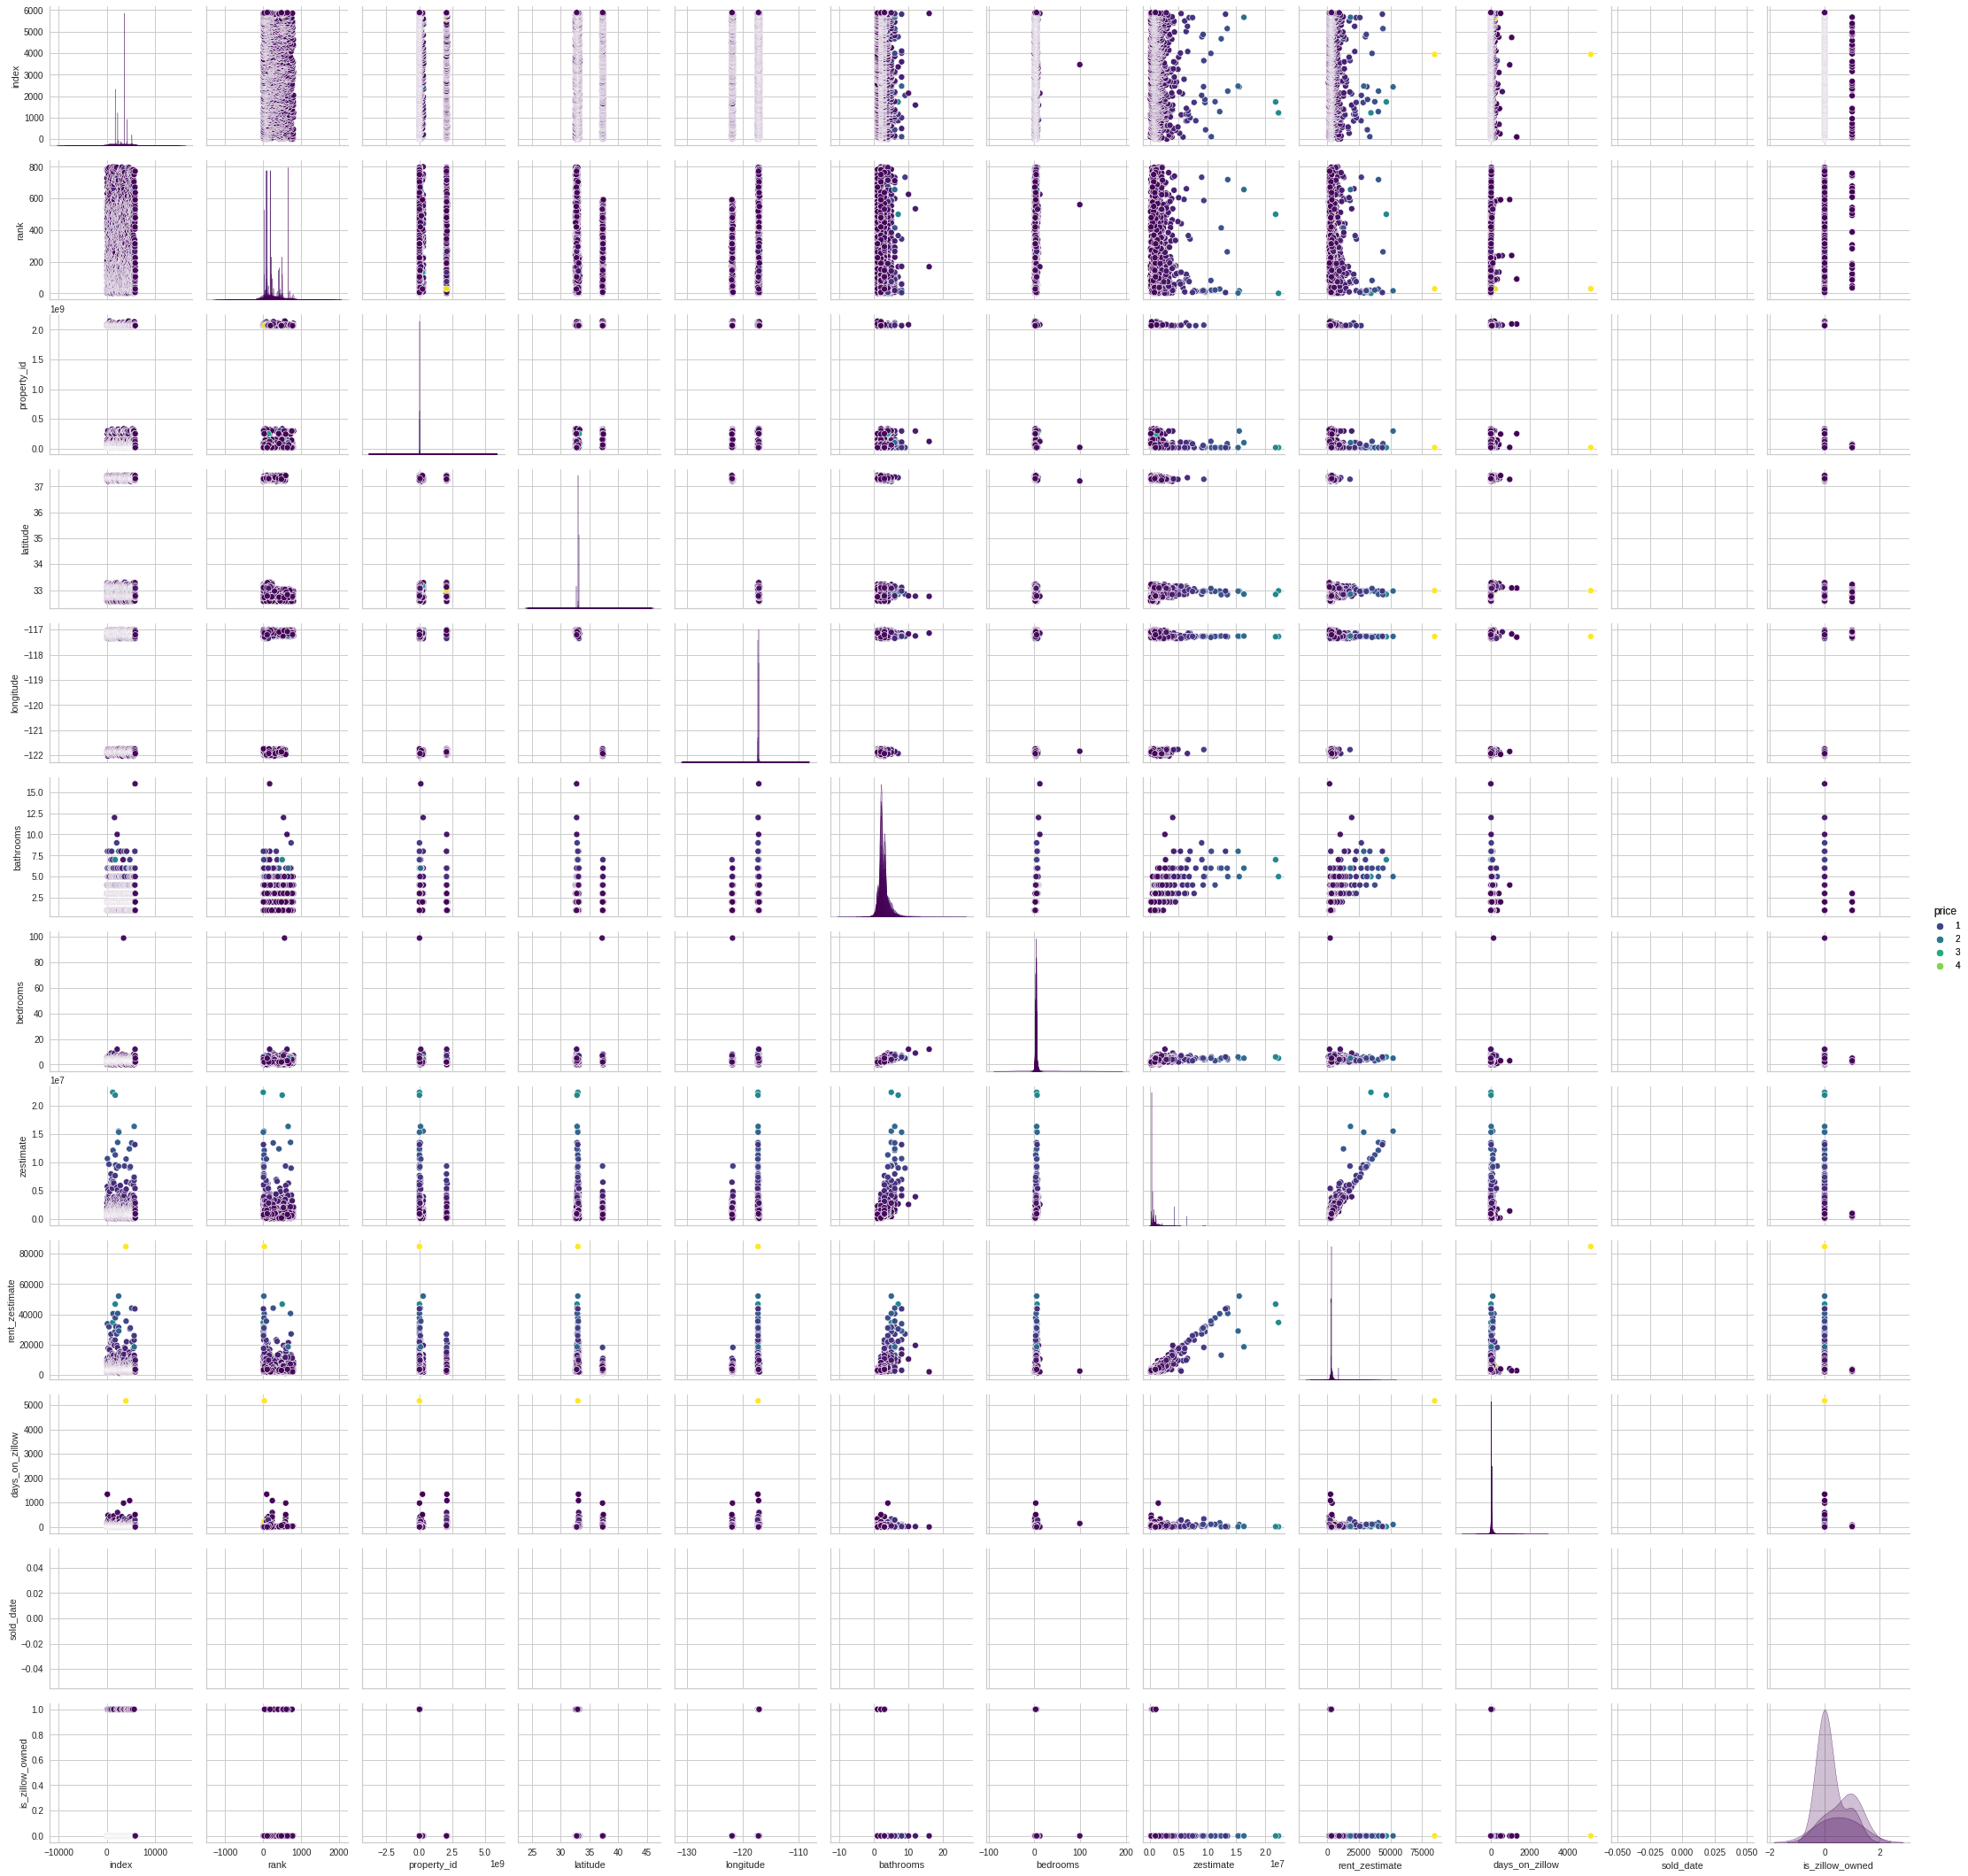

In [ ]:
sns.pairplot(df_cali, hue='price', palette='viridis').add_legend()
plt.show()

The above pairplot provides how price is associated with the other features like bedroom, bathroom. zestimate etc.

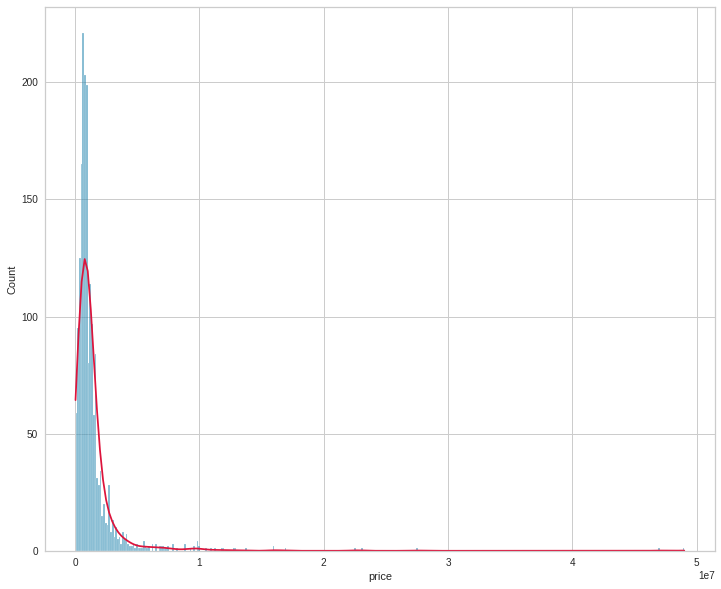

In [ ]:
plt.figure(figsize=(12,10))
ax = sns.histplot(data=df_cali, x='price', color='b', kde=True)
ax.lines[0].set_color('crimson')
plt.show()

The above plot provides skewness of the price

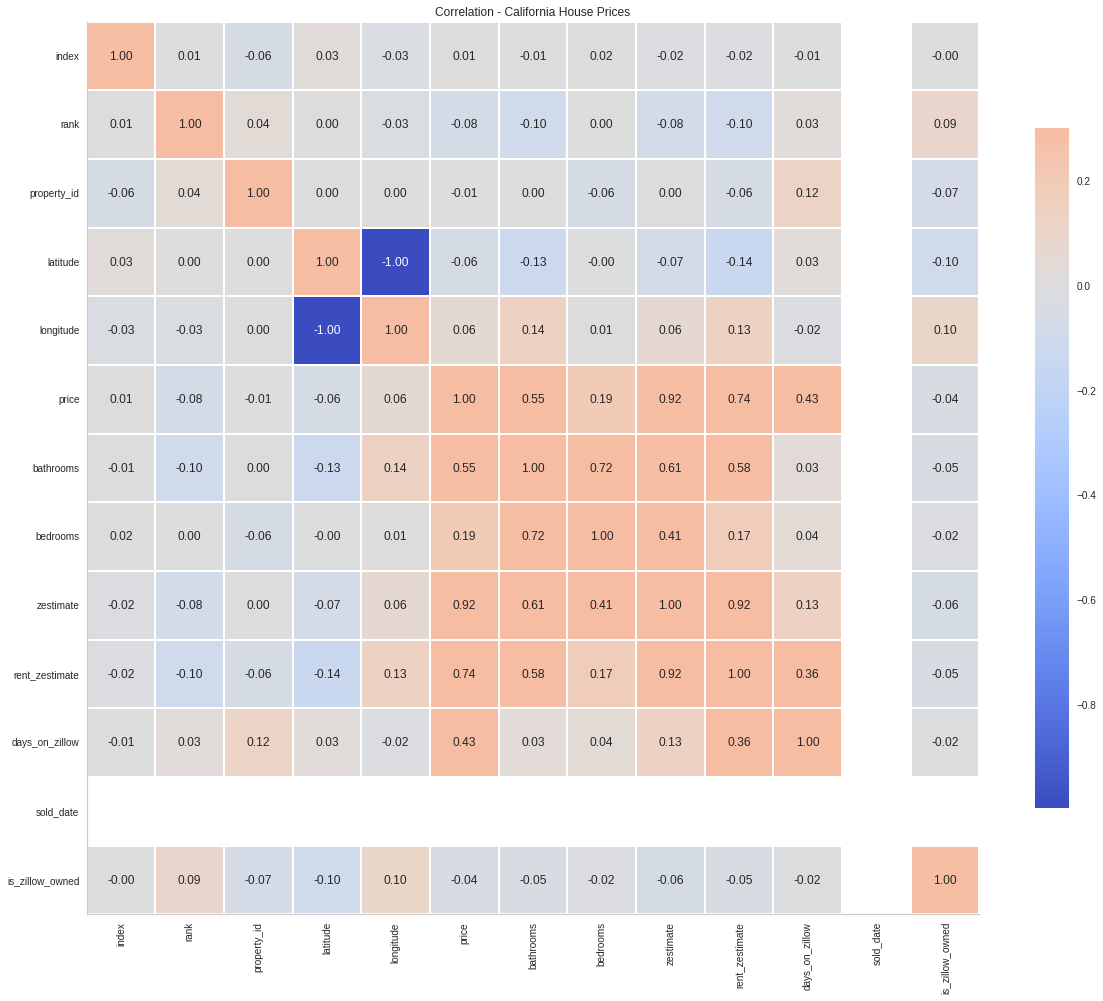

In [ ]:
corr = df_cali.corr()
g = sns.heatmap(corr,  vmax=.3, center=0,square=True, linewidths=1, cbar_kws={"shrink": 0.5}, annot=True, fmt='.2f', cmap='coolwarm')
sns.despine()
g.figure.set_size_inches(20,25)
plt.title('Correlation - California House Prices')
plt.show()

The above heatmap provides correlation between all the columns present in the dataset.

In [ ]:
df_cali['listing_type'].unique()

array(['House for sale', 'Condo for sale', 'Home for sale',
       'Multi-family home for sale', 'Coming soon', 'Lot / Land for sale',
       'New construction', 'Townhouse for sale', 'Foreclosure'],
      dtype=object)

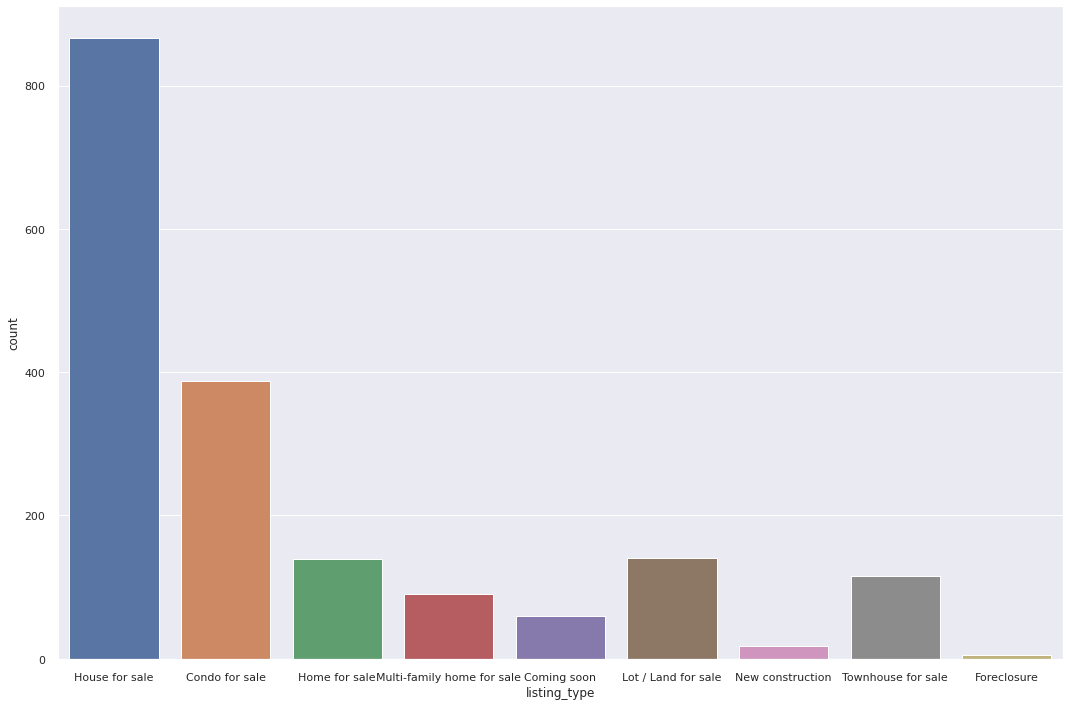

In [ ]:
plt.figure(figsize=(18,12))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="listing_type", data=df_cali)

In [ ]:
listing_type = df_cali.groupby(["listing_type"])
sum_listing_type = listing_type["price"].mean()
rent_listing_type=listing_type["rent_zestimate"].mean()
print (sum_listing_type, rent_listing_type)

listing_type
Coming soon                  1093159.95000
Condo for sale                751726.29124
Foreclosure                  1851600.00000
Home for sale                 252138.34532
House for sale               1805057.85928
Lot / Land for sale          1905853.74286
Multi-family home for sale   2020287.35165
New construction             3390059.50000
Townhouse for sale            894302.68696
Name: price, dtype: float64 listing_type
Coming soon                   4263.08000
Condo for sale                3085.99424
Foreclosure                   4009.00000
Home for sale                 2916.48305
House for sale                5515.13117
Lot / Land for sale           3113.42975
Multi-family home for sale    4050.03797
New construction             11337.50000
Townhouse for sale            3422.83178
Name: rent_zestimate, dtype: float64


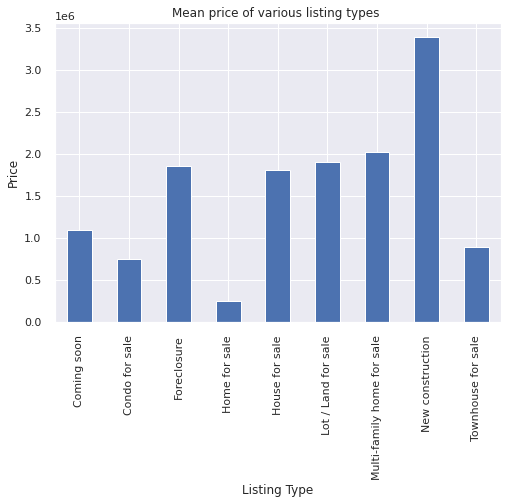

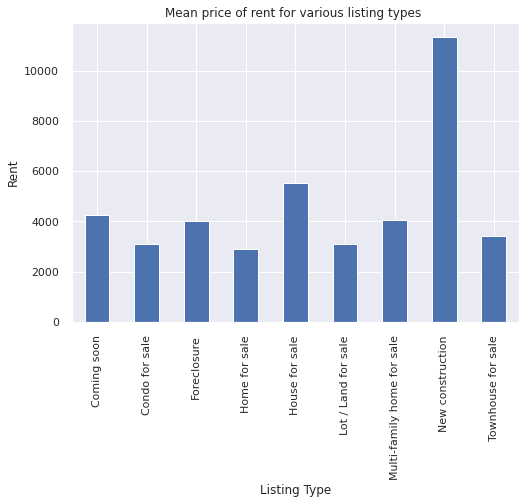

In [ ]:
sum_listing_type.plot(kind="bar")
plt.title("Mean price of various listing types ")
plt.ylabel("Price")
plt.xlabel("Listing Type")
plt.show()
rent_listing_type.plot(kind="bar")
plt.title("Mean price of rent for various listing types ")
plt.ylabel("Rent")
plt.xlabel("Listing Type")
plt.show()

In [ ]:
fig = px.histogram(df_cali, x='price', y='zestimate', color='listing_type', histfunc='avg', hover_data=df_cali.columns, template='seaborn')
fig.show()

In [ ]:
df_cali.isna().sum().sort_values(ascending=False)

sold_date          1824
land_area          1683
broker_name        1305
zestimate           344
bathrooms           185
bedrooms            169
rent_zestimate      151
area                148
latitude              8
longitude             8
days_on_zillow        3
price                 0
rank                  0
property_id           0
address               0
listing_url           0
currency              0
property_url          0
is_zillow_owned       0
image                 0
listing_type          0
input                 0
index                 0
dtype: int64

Summary

## Data Preparation

Formatting and converting features. Also handling missing and duplicate values (if any) in the dataset.

In [ ]:
df_cali['area_sqft'] = df_cali['area'].str.replace('\ssqft', '0', regex=True)
df_cali.head()

,index,rank,property_id,address,latitude,longitude,price,currency,bathrooms,bedrooms,area,land_area,zestimate,rent_zestimate,days_on_zillow,sold_date,is_zillow_owned,image,listing_type,broker_name,input,property_url,listing_url,area_sqft
0,8,24,16713230,"545 Ocean View Ave, Encinitas, CA 92024",33.05894,-117.29190,2799900.00000,USD,4.00000,4.00000,3164.0 sqft,NaN,2951100.00000,8486.00000,9.00000,nan,False,https://photos.zillowstatic.com/fp/5df598bdc169d389a30c47ba1e67ec64-p_e.jpg,House for sale,"eXp Realty of California, Inc.","https://www.zillow.com/homes/Encinitas,-CA_rb/",https://www.zillow.com/homedetails/545-Ocean-View-Ave-Encinitas-CA-92024/16713230_zpid/,"https://www.zillow.com/homes/Encinitas,-CA_rb/",3164.00
1,9,728,72109285,"350 11th Ave UNIT 224, San Diego, CA 92101",32.70899,-117.15484,674900.00000,USD,2.00000,2.00000,1078.0 sqft,NaN,nan,nan,25.00000,nan,False,https://photos.zillowstatic.com/fp/057244ef1708e132ddbb5f5cff22839c-p_e.jpg,Condo for sale,NaN,"https://www.zillow.com/homes/San-Diego,-CA_rb/",https://www.zillow.com/homedetails/350-11th-Ave-UNIT-224-San-Diego-CA-92101/72109285_zpid/,"https://www.zillow.com/homes/San-Diego,-CA_rb/19_p/",1078.00
2,12,105,16649104,"1735 Kirk Pl, Carlsbad, CA 92008",33.15492,-117.32334,1695000.00000,USD,2.00000,4.00000,2132.0 sqft,NaN,1714700.00000,3200.00000,63.00000,nan,False,https://photos.zillowstatic.com/fp/08c1e6f153b9eb1acd7b1317a6ab3afa-p_e.jpg,House for sale,Pacific Investment Properties,"https://www.zillow.com/homes/carlsbad,-CA_rb/",https://www.zillow.com/homedetails/1735-Kirk-Pl-Carlsbad-CA-92008/16649104_zpid/,"https://www.zillow.com/homes/carlsbad,-CA_rb/3_p/",2132.00
3,15,778,88783088,"825 W Beech St UNIT 301, San Diego, CA 92101",32.72032,-117.17048,779000.00000,USD,3.00000,2.00000,1282.0 sqft,NaN,774700.00000,3566.00000,29.00000,nan,False,https://photos.zillowstatic.com/fp/b65f7892a398c20b91ec507f5bf4d050-p_e.jpg,Condo for sale,NaN,"https://www.zillow.com/homes/San-Diego,-CA_rb/",https://www.zillow.com/homedetails/825-W-Beech-St-UNIT-301-San-Diego-CA-92101/88783088_zpid/,"https://www.zillow.com/homes/San-Diego,-CA_rb/20_p/",1282.00
4,17,423,2068655346,"96 Quail Hollow Dr, San Jose, CA 95128",37.29826,-121.93468,269000.00000,USD,2.00000,2.00000,1440.0 sqft,NaN,nan,2914.00000,38.00000,nan,False,https://photos.zillowstatic.com/fp/c46224421320696ee1acb773343d25d5-p_e.jpg,Home for sale,NaN,"https://www.zillow.com/homes/san-jose,-CA_rb/",https://www.zillow.com/homedetails/96-Quail-Hollow-Dr-San-Jose-CA-95128/2068655346_zpid/,"https://www.zillow.com/homes/san-jose,-CA_rb/11_p/",1440.00


In [ ]:
df_cali.listing_type.unique()

array([4, 1, 3, 6, 0, 5, 7, 8, 2], dtype=int8)

In [ ]:
List_Of_Categories_In_Column=list(df_cali['listing_type'].value_counts().index)
List_Of_Categories_In_Column

[4, 1, 5, 3, 8, 6, 0, 7, 2]

In [ ]:
df_cali['area_sqft'] = df_cali['area_sqft'].astype(float)

In [ ]:
# converting string attributes to the codes
#df_cali['address'] = df_cali['address'].astype('category').cat.codes
df_cali['area'] = df_cali['area'].astype('category').cat.codes
df_cali['listing_type'] = df_cali['listing_type'].astype('category').cat.codes
df_cali['broker_name'] = df_cali['broker_name'].astype('category').cat.codes
df_cali['input'] = df_cali['input'].astype('category').cat.codes
df_cali['image'] = df_cali['image'].astype('category').cat.codes
df_cali['listing_url'] = df_cali['listing_url'].astype('category').cat.codes

In [ ]:
columns = ['area','image', 'listing_type', 'broker_name', 'input', 'listing_url'] # 'address'
df_feat = df_cali.copy()
df_feat[columns] = df_feat[columns].apply(lambda x: x.astype('category').cat.codes)
df_feat.dtypes

index                int64
rank                 int64
property_id          int64
address             object
latitude           float64
longitude          float64
price              float64
currency            object
bathrooms          float64
bedrooms           float64
area                 int16
land_area           object
zestimate          float64
rent_zestimate     float64
days_on_zillow     float64
sold_date          float64
is_zillow_owned       bool
image                int16
listing_type          int8
broker_name          int16
input                 int8
property_url        object
listing_url           int8
area_sqft          float64
dtype: object

In [ ]:
df_feat.isna().sum().sort_values(ascending=False)

sold_date          1824
land_area          1683
zestimate           344
bathrooms           185
bedrooms            169
rent_zestimate      151
area_sqft           148
latitude              8
longitude             8
days_on_zillow        3
is_zillow_owned       0
currency              0
rank                  0
property_id           0
address               0
price                 0
property_url          0
image                 0
input                 0
area                  0
listing_url           0
broker_name           0
listing_type          0
index                 0
dtype: int64

In [ ]:
# dropping following columns which are redundant and/or have too many missing values
cols = ['sold_date', 'currency', 'is_zillow_owned', 'land_area']
df_feat.drop(columns=cols, axis=1, inplace=True)
df_feat.head()

,index,rank,property_id,address,latitude,longitude,price,bathrooms,bedrooms,area,zestimate,rent_zestimate,days_on_zillow,image,listing_type,broker_name,input,property_url,listing_url,area_sqft
0,8,24,16713230,"545 Ocean View Ave, Encinitas, CA 92024",33.05894,-117.29190,2799900.00000,4.00000,4.00000,804,2951100.00000,8486.00000,9.00000,679,4,217,1,https://www.zillow.com/homedetails/545-Ocean-View-Ave-Encinitas-CA-92024/16713230_zpid/,1,3164.00000
1,9,728,72109285,"350 11th Ave UNIT 224, San Diego, CA 92101",32.70899,-117.15484,674900.00000,2.00000,2.00000,43,nan,nan,25.00000,57,1,0,3,https://www.zillow.com/homedetails/350-11th-Ave-UNIT-224-San-Diego-CA-92101/72109285_zpid/,20,1078.00000
2,12,105,16649104,"1735 Kirk Pl, Carlsbad, CA 92008",33.15492,-117.32334,1695000.00000,2.00000,4.00000,589,1714700.00000,3200.00000,63.00000,78,4,132,4,https://www.zillow.com/homedetails/1735-Kirk-Pl-Carlsbad-CA-92008/16649104_zpid/,32,2132.00000
3,15,778,88783088,"825 W Beech St UNIT 301, San Diego, CA 92101",32.72032,-117.17048,779000.00000,3.00000,2.00000,162,774700.00000,3566.00000,29.00000,1307,1,0,3,https://www.zillow.com/homedetails/825-W-Beech-St-UNIT-301-San-Diego-CA-92101/88783088_zpid/,21,1282.00000
4,17,423,2068655346,"96 Quail Hollow Dr, San Jose, CA 95128",37.29826,-121.93468,269000.00000,2.00000,2.00000,248,nan,2914.00000,38.00000,1412,3,0,5,https://www.zillow.com/homedetails/96-Quail-Hollow-Dr-San-Jose-CA-95128/2068655346_zpid/,36,1440.00000


In [ ]:
df_feat.isna().sum().sort_values(ascending=False)

zestimate         344
bathrooms         185
bedrooms          169
rent_zestimate    151
area_sqft         148
latitude            8
longitude           8
days_on_zillow      3
rank                0
property_id         0
address             0
price               0
area                0
listing_url         0
image               0
listing_type        0
broker_name         0
input               0
property_url        0
index               0
dtype: int64

In [ ]:
df_feat = df_feat.dropna()
df_feat = df_feat.reset_index(drop=True)
df_feat.shape

(1426, 20)

In [ ]:
print('Number of Duplicate rows = ', (df_feat.duplicated()).sum())

Number of Duplicate rows =  0


In [ ]:
# df_feat.to_csv('/content/drive/MyDrive/CMPE255 - Data Mining/CMPE255-DM-Project/Dataset/cleaned.csv', index=False)
df_feat.to_csv('/content/drive/MyDrive/CMPE255-DM-Project/Dataset/cleaned.csv', index=False)

In [ ]:
# Anastasia's path
# path = '/content/drive/MyDrive/DataMining/Dataset/cleaned.csv'
# path = '/content/drive/MyDrive/CMPE255 - Data Mining/CMPE255-DM-Project/Dataset/cleaned.csv'

# parvathis path
path="/content/drive/MyDrive/CMPE255-DM-Project/Dataset/cleaned.csv"
df_feat = pd.read_csv(path)

## Outliers removal

As part of data preparation we performed the outliers analysis on the dataset. Outlier detection and removal is a very important step for any machine learning project and if identified early in the process helps with less loss and better model performance, it can affect the accuracy and prediction. 


In [ ]:
# for outlier identification instead of 1 standart deviation I used 2 standart deviations
def remove_outliers(df, group_column, feature):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby(group_column):
        m = np.mean(subdf[feature])
        st = np.std(subdf[feature])
        reduced_df = subdf[(subdf[feature]>(m-(2 * st))) & (subdf[feature]<=(m+(2 *st)))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out

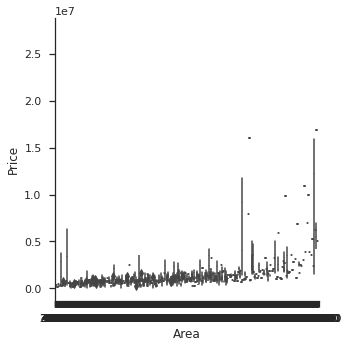

In [ ]:
with sns.axes_style(style='ticks'):
  g = sns.catplot('area_sqft', 'price', data=df_feat, kind="box")
  g.set_axis_labels("Area", "Price")

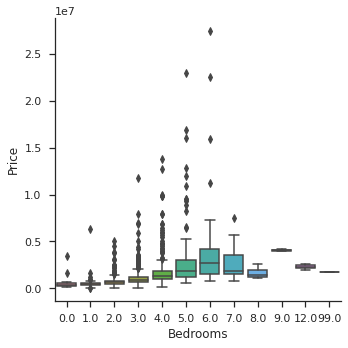

In [ ]:
with sns.axes_style(style='ticks'):
  g = sns.catplot('bedrooms', 'price', data=df_feat, kind="box")
  g.set_axis_labels("Bedrooms", "Price")

Remove records with more than 8 rooms

In [ ]:
df_filtered = df_feat[df_feat['bedrooms'] < 9].copy()

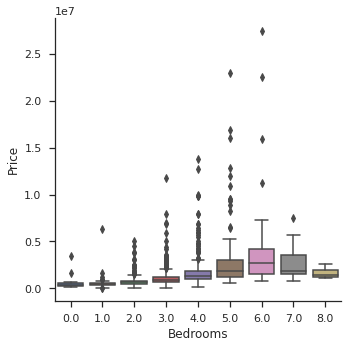

In [ ]:
with sns.axes_style(style='ticks'):
  g = sns.catplot('bedrooms', 'price', data=df_filtered, kind="box")
  g.set_axis_labels("Bedrooms", "Price")

Remove records that are twice the std div. from the mean

In [ ]:
df_filtered = remove_outliers(df_filtered, 'bedrooms', 'price')
df_filtered.shape

(1591, 20)

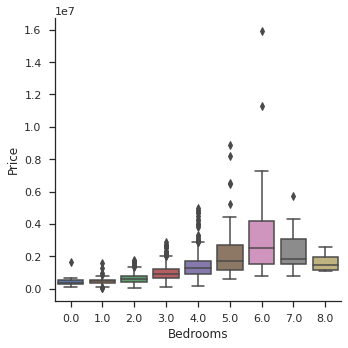

In [ ]:
with sns.axes_style(style='ticks'):
  g = sns.catplot('bedrooms', 'price', data=df_filtered, kind="box")
  g.set_axis_labels("Bedrooms", "Price")

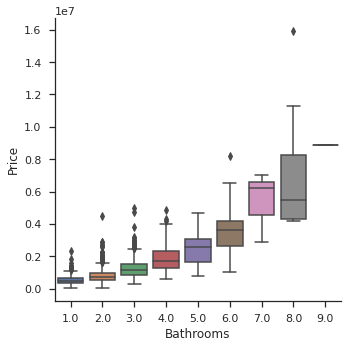

In [ ]:
with sns.axes_style(style='ticks'):
  g = sns.catplot('bathrooms', 'price', data=df_filtered, kind="box")
  g.set_axis_labels("Bathrooms", "Price")

In [ ]:
df_feat.shape

(1824, 20)

In [ ]:
df_filtered = df_filtered[df_filtered['bathrooms'] < 9]

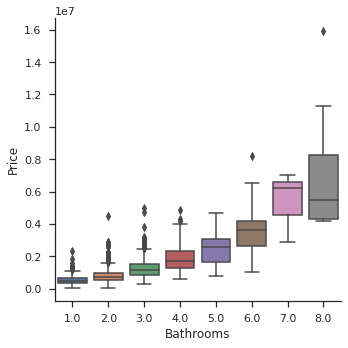

In [ ]:
with sns.axes_style(style='ticks'):
  g = sns.catplot('bathrooms', 'price', data=df_filtered, kind="box")
  g.set_axis_labels("Bathrooms", "Price")

In [ ]:
fig = px.scatter_mapbox(df_filtered, lat='latitude', lon='longitude', color="bedrooms", hover_data=['price', 'area_sqft', 'bedrooms', 'bathrooms'])
fig.update_layout(mapbox_style="open-street-map")
fig.show()

In [ ]:
# inspired by Kaggle EDA & Auto ML - House Prices 
def categorial_feature_overview(df, feature, rotation=0):
    print(feature.upper())
    f,ax = plt.subplots(1, 2, figsize=(20, 6))
    ax[0].tick_params(labelrotation=rotation)
    ax[1].tick_params(labelrotation=rotation)
    sns.boxplot(data=df, x=feature, y='price', ax=ax[1])
    sns.countplot(data=df, x=feature, ax=ax[0]);
    plt.show()
    
def numerical_feature_overview(df, feature, rotation=0):
    print(feature.upper())
    f,ax = plt.subplots(1, 2, figsize=(20, 6))
    ax[0].tick_params(labelrotation=rotation)
    ax[1].tick_params(labelrotation=rotation)
    sns.scatterplot(data=df, x=feature, y='price', ax=ax[0]);
    sns.boxplot(data=df, x=feature, ax=ax[1])
    plt.show()

LISTING_TYPE


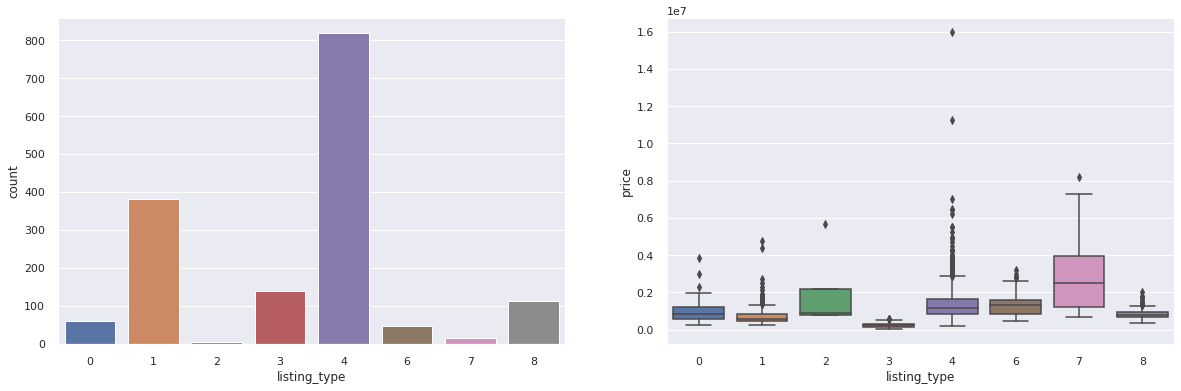

In [ ]:
categorial_feature_overview(df_filtered, 'listing_type')

BEDROOMS


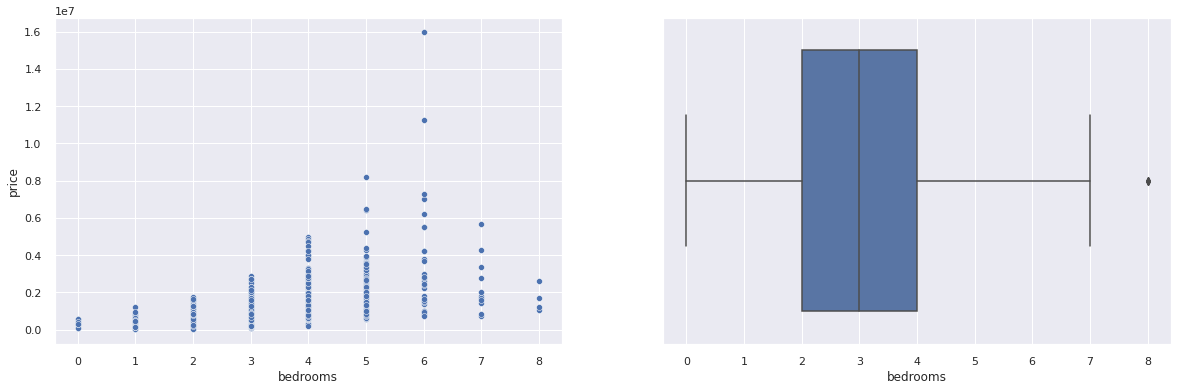

In [ ]:
numerical_feature_overview(df_filtered, 'bedrooms')

BATHROOMS


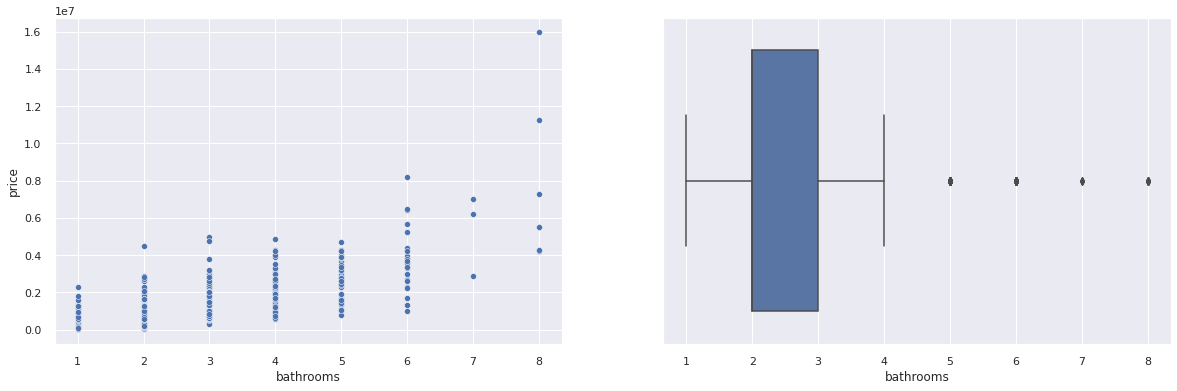

In [ ]:
numerical_feature_overview(df_filtered, 'bathrooms')

AREA_SQFT


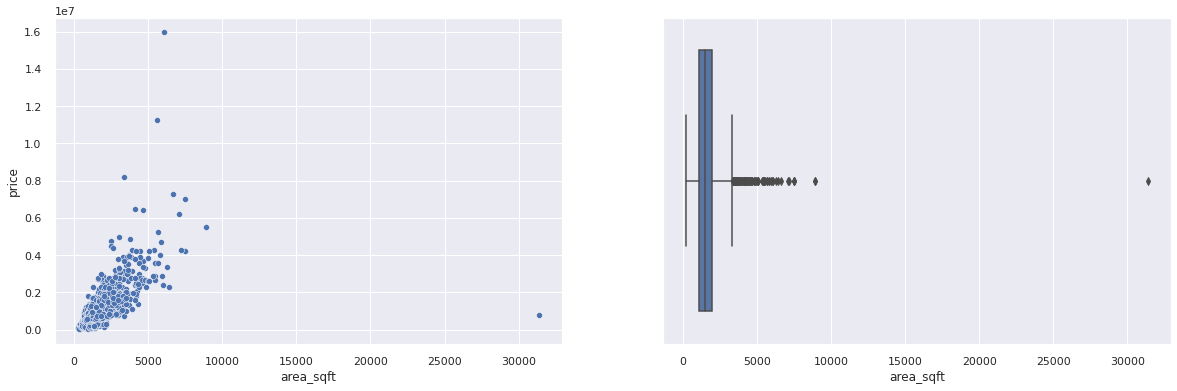

In [ ]:
numerical_feature_overview(df_filtered, 'area_sqft')

In [ ]:
df_filtered = df_filtered[df_filtered['area_sqft'] < 15000]

In [ ]:
df_filtered = df_filtered[df_filtered['price'] < 8000000]

In [ ]:
df_filtered.shape

(1561, 20)

AREA_SQFT


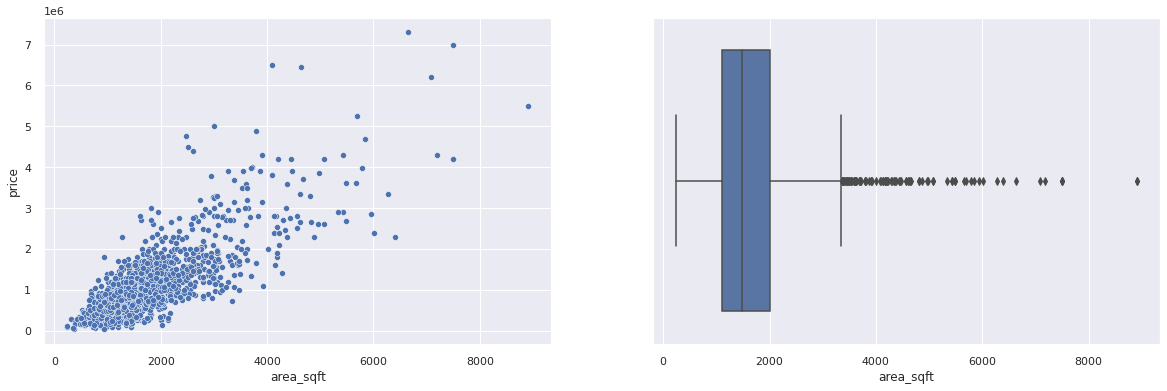

In [ ]:
numerical_feature_overview(df_filtered, 'area_sqft')

## Feature engineering

The feature engineering is the constructing and formatting data step that transforms raw data into features that can be used in machine learning algorithms, such as predictive models. 

In [ ]:
def getZipCode(address):
  if not address:
    return None
  zipCode = address.split(' ').pop()
  return int(zipCode)
df_filtered['zip_code'] =df_filtered.address.apply(getZipCode)

In [ ]:
df_filtered.head(1)

,index,rank,property_id,address,latitude,longitude,price,bathrooms,bedrooms,area,zestimate,rent_zestimate,days_on_zillow,image,listing_type,broker_name,input,property_url,listing_url,area_sqft,zip_code
0,218,121,63790538,"1150 J St UNIT 222, San Diego, CA 92101",32.70972,-117.15419,374900.00000,1.00000,0.00000,1014,356700.00000,2100.00000,1.00000,1129,1,-1,3,https://www.zillow.com/homedetails/1150-J-St-UNIT-222-San-Diego-CA-92101/63790538_zpid/,24,744.00000,92101


In [ ]:
# df_filtered.to_csv('/content/drive/MyDrive/DataMining/Dataset/feat_eng.csv', index=False)
## Parvathis path
df_filtered.to_csv('/content/drive/MyDrive/CMPE255-DM-Project/Dataset/feat_eng.csv', index=False)


In [ ]:
# df_filtered = pd.read_csv('/content/drive/MyDrive/CMPE255 - Data Mining/CMPE255-DM-Project/Dataset/feat_eng.csv')
df_filtered = pd.read_csv('/content/drive/MyDrive/CMPE255-DM-Project/Dataset/feat_eng.csv')

In [ ]:
df_filtered.head(1)

,index,rank,property_id,address,latitude,longitude,price,bathrooms,bedrooms,area,zestimate,rent_zestimate,days_on_zillow,image,listing_type,broker_name,input,property_url,listing_url,area_sqft,zip_code
0,218,121,63790538,"1150 J St UNIT 222, San Diego, CA 92101",32.70972,-117.15419,374900.00000,1.00000,0.00000,1014,356700.00000,2100.00000,1.00000,1129,1,-1,3,https://www.zillow.com/homedetails/1150-J-St-UNIT-222-San-Diego-CA-92101/63790538_zpid/,24,744.00000,92101


In [ ]:
df_filtered.dtypes

index               int64
rank                int64
property_id         int64
address            object
latitude          float64
longitude         float64
price             float64
bathrooms         float64
bedrooms          float64
area                int64
zestimate         float64
rent_zestimate    float64
days_on_zillow    float64
image               int64
listing_type        int64
broker_name         int64
input               int64
property_url       object
listing_url         int64
area_sqft         float64
zip_code            int64
dtype: object

## Feature importance


Feature importance helps us to estimate how much each feature contributes to the model performance/prediction. We have calculated the feature importance by using SHAP (Shapely Additive Explanation).

In [ ]:
df_fe = df_filtered.drop(['property_url', 'broker_name', 'input', 'image', 'listing_url', 'area', 'zestimate', 'rent_zestimate', 'address', 'days_on_zillow'], axis=1)

In [ ]:
df_fe.dropna(inplace=True)

In [ ]:
# removing the columns with url, area as created aseparate float data type column and land_area
X = df_fe.drop(['price'], axis=1) 
y = df_fe['price'].copy()

In [ ]:
X.shape

(1559, 10)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [ ]:
X_sc = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_sc, y, test_size=0.20)

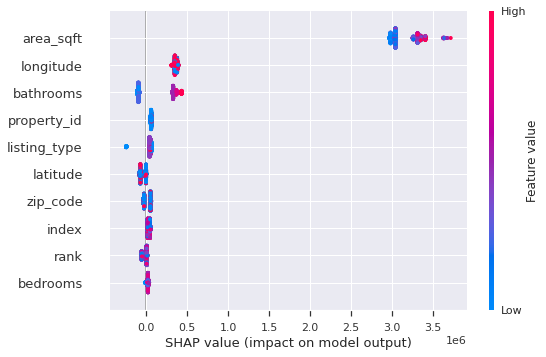

In [ ]:
ranfrcls = RandomForestRegressor()
ranfrcls.fit(X_train,y_train)
explainer = shap.TreeExplainer(ranfrcls)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

## Dataset for training model

Following features specific to zillow does not have any impact on the price so can be ignored -
* rank
* index
* property id
* zestimate 
* rent_zestimate
* days_on_zillow
* image etc..

Also we will work with zipcode so not including longitude and latitude. Similarly for area se created a float dtype feature area_sqft which is used.

In [ ]:
df_fe.columns

Index(['index', 'rank', 'property_id', 'latitude', 'longitude', 'price',
       'bathrooms', 'bedrooms', 'listing_type', 'area_sqft', 'zip_code'],
      dtype='object')

In [ ]:
df_final = df_fe.drop(['index', 'rank', 'property_id', 'latitude', 'longitude'], axis=1)

In [ ]:
df_final.shape

(1559, 6)

In [ ]:
df_final.isna().sum()

price           0
bathrooms       0
bedrooms        0
listing_type    0
area_sqft       0
zip_code        0
dtype: int64

In [ ]:
df_final.info(0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1559 entries, 0 to 1558
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         1559 non-null   float64
 1   bathrooms     1559 non-null   float64
 2   bedrooms      1559 non-null   float64
 3   listing_type  1559 non-null   int64  
 4   area_sqft     1559 non-null   float64
 5   zip_code      1559 non-null   int64  
dtypes: float64(4), int64(2)
memory usage: 73.2 KB


In [ ]:
df_final.head()

,price,bathrooms,bedrooms,listing_type,area_sqft,zip_code
0,374900.00000,1.00000,0.00000,1,744.00000,92101
1,269900.00000,1.00000,0.00000,1,480.00000,92026
2,509000.00000,1.00000,0.00000,1,519.00000,95110
3,279900.00000,1.00000,0.00000,4,311.00000,92101
4,99900.00000,1.00000,0.00000,3,240.00000,92024


In [ ]:
df_final.to_csv('/content/drive/MyDrive/DM-project/df_final.csv', index=False)

In [ ]:
train, test = train_test_split(df_final)

In [ ]:
train.to_csv('/content/drive/MyDrive/DM-project/train.csv', index=False)
test.to_csv('/content/drive/MyDrive/DM-project/test.csv', index=False)

In [ ]:
df_final.listing_type.unique()

array([1, 4, 3, 0, 8, 6, 7, 2])

In [ ]:
# df_final.to_csv('/content/drive/MyDrive/CMPE255 - Data Mining/CMPE255-DM-Project/Dataset/df_final.csv', index=False)
df_final.to_csv('/content/drive/MyDrive/CMPE255-DM-Project/Dataset/df_final.csv', index=False)

## Train Test Split

In [ ]:
# df_final = pd.read_csv('/content/drive/MyDrive/CMPE255 - Data Mining/CMPE255-DM-Project/Dataset/df_final.csv')
df_final = pd.read_csv('/content/drive/MyDrive/CMPE255-DM-Project/Dataset/df_final.csv')
df_final.head(1)

,price,bathrooms,bedrooms,listing_type,area_sqft,zip_code
0,374900.00000,1.00000,0.00000,1,744.00000,92101


In [ ]:
X = df_final.drop(['price'], axis=1)
y = df_final['price'].copy()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Regression Loop

Running multiple regressors in a loop to determine which regressor gives best results. We will use the best performing model for predictions.

In [ ]:
regressors = []
regressors.append(('Linear Regression', LinearRegression(), False))
regressors.append(('Logistic Regression', LogisticRegression(), False))
regressors.append(('KNN Regression', KNeighborsRegressor(n_neighbors=2, weights='uniform'), False))
regressors.append(('Random Forest Regression', RandomForestRegressor(n_estimators = 500, random_state = 102), False))
regressors.append(('AdaBoost Regression', AdaBoostRegressor(n_estimators=50, random_state=None), False))
regressors.append(("Cat Boost", CatBoostRegressor(loss_function="RMSE"), True))
regressors.append(("Light Gradient Boosting", LGBMRegressor(), True))
regressors.append(("EXtreme Gradient Boosting", XGBRegressor(objective='reg:squarederror'), True))

In [ ]:
def model_loop_regressors(models, X_train, X_test, y_train, y_test, X, y):
  results = []
  trained_models = []
  for (name, model, flag) in models:
    print(name)
    start_time = time()
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    n_scores = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')
    model.fit(X_train, y_train)
    run_time = time() - start_time
    trained_models.append([name, model])

    if flag == True:
      print("Model: ", name)
      explainer = shap.TreeExplainer(model)
      shap_values = explainer.shap_values(X)
      shap.summary_plot(shap_values, X)

    accuracy = model.score(X_test, y_test)
    results.append([name, np.mean(n_scores), accuracy, run_time])
  return results, trained_models

Linear Regression
Logistic Regression
KNN Regression
Random Forest Regression
AdaBoost Regression
Cat Boost
Learning rate set to 0.042396
0:	learn: 811060.7774251	total: 47.8ms	remaining: 47.8s
1:	learn: 792204.1790989	total: 49.2ms	remaining: 24.5s
2:	learn: 775045.9707343	total: 50.7ms	remaining: 16.9s
3:	learn: 758754.3513344	total: 51.6ms	remaining: 12.8s
4:	learn: 743458.9204599	total: 52.7ms	remaining: 10.5s
5:	learn: 728809.2845002	total: 53.8ms	remaining: 8.92s
6:	learn: 714250.2297598	total: 56.5ms	remaining: 8.01s
7:	learn: 699717.5973048	total: 58.4ms	remaining: 7.24s
8:	learn: 686597.9993031	total: 59.5ms	remaining: 6.55s
9:	learn: 673851.9478355	total: 60.6ms	remaining: 6s
10:	learn: 662482.5658482	total: 61.7ms	remaining: 5.55s
11:	learn: 651290.1027978	total: 63.1ms	remaining: 5.19s
12:	learn: 640061.7412973	total: 64.2ms	remaining: 4.87s
13:	learn: 630219.0404386	total: 65.4ms	remaining: 4.61s
14:	learn: 621210.2560984	total: 66.7ms	remaining: 4.38s
15:	learn: 610469.56

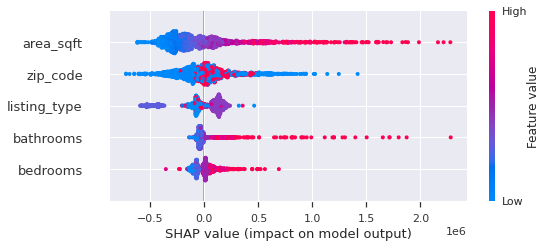

Light Gradient Boosting
Model:  Light Gradient Boosting


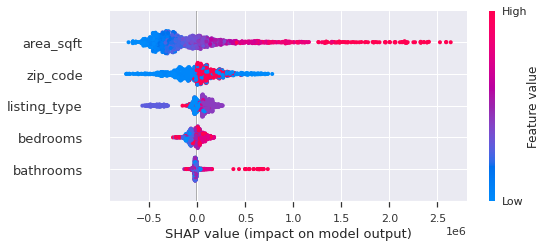

EXtreme Gradient Boosting
Model:  EXtreme Gradient Boosting


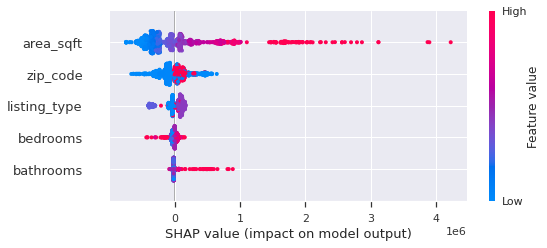

In [ ]:
result_final, trained_models = model_loop_regressors(regressors, X_train, X_test, y_train, y_test, X, y)

## Evaluate


After training various regression models we compare them on different metrics like accuracy, mean score and overall time taken to fit the training data.

In [ ]:
df_results = pd.DataFrame(result_final, columns=['Model Name', 'Mean', 'Accuracy', 'Time Taken'])
df_results

,Model Name,Mean,Accuracy,Time Taken
0,Linear Regression,0.63743,0.71730,1.63123
1,Logistic Regression,0.40689,0.02564,155.97161
2,KNN Regression,0.49565,0.54353,0.27786
3,Random Forest Regression,0.76413,0.82600,48.56526
4,AdaBoost Regression,0.56966,0.63713,2.14880
5,Cat Boost,0.79529,0.85028,35.61911
6,Light Gradient Boosting,0.77964,0.82592,1.97072
7,EXtreme Gradient Boosting,0.77878,0.80796,1.94366


## Save the Best Model

In [ ]:
model_1 = trained_models[7][1] # xgboost

model_2 = trained_models[3][1] # random forest

In [ ]:
# filename_1 = '/content/drive/MyDrive/CMPE255 - Data Mining/CMPE255-DM-Project/models/model_1.sav'
## pickle model
filename_1 = '/content/drive/MyDrive/CMPE255-DM-Project/models/model_1.pkl'

pickle.dump(model_1, open(filename_1, 'wb'))

In [ ]:
# filename_2 = '/content/drive/MyDrive/CMPE255 - Data Mining/CMPE255-DM-Project/models/model_2.sav'
filename_2 = '/content/drive/MyDrive/CMPE255-DM-Project/models/model_2.pkl'

pickle.dump(model_2, open(filename_2, 'wb'))

In [ ]:
loaded_model = pickle.load(open(filename_1, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.8079630578226664


## Regression plot

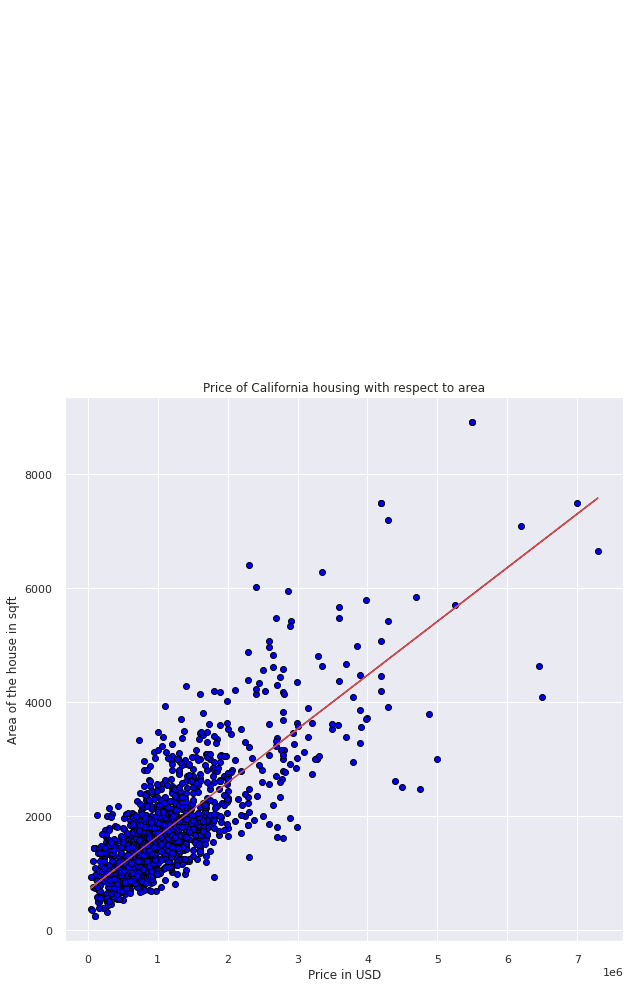

In [ ]:
fig = plt.figure(figsize=(10,10))
acres_burned = df_final["area_sqft"].tolist()
alt = df_final['price'].tolist()
plt.scatter(alt, acres_burned, marker="o", facecolors="blue", edgecolors="black")
plt.title("Price of California housing with respect to area")
plt.xlabel("Price in USD")
plt.ylabel("Area of the house in sqft")
x_values = df_final['price']
y_values = df_final['area_sqft']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(2000,16000),fontsize=15,color="red");



---



---



# References